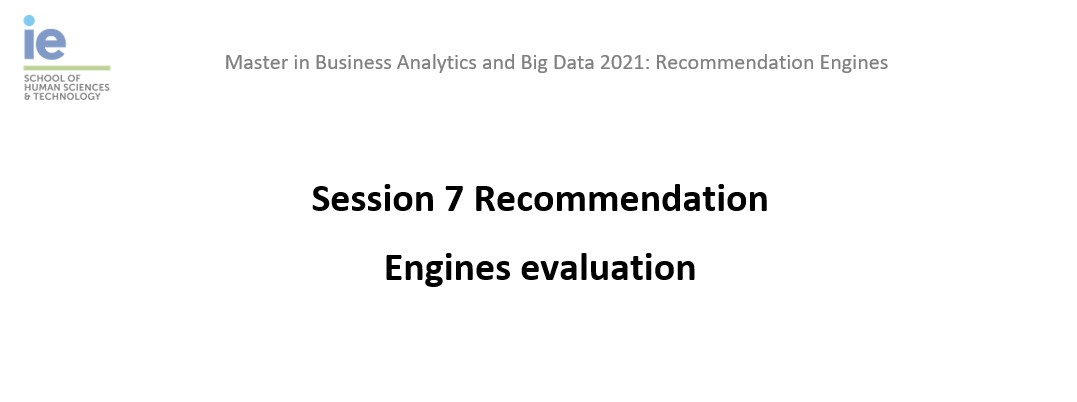

# Splitting the dataset

To evaluate models, we need to build them with some data and test them on some
other data. The surprise package contains prebuilt tools that help us in this task.

The target is to define two datasets, which are as follows:
- **Training set:** This set includes users from which the model learns
- **Test set:** This set includes users to whom we recommend movies

As we saw in session 6 in order to measure model's perfomance is important to have clear if we are using either a **classification (like/dislike) or regression(ratings) approach. Because performance metrics are dependant on the  approach choosen.** 


## Simple split

The easiest way to build a training and test set is to split the data in two parts. First, we need to decide how many users to put into each part. For instance, we can put 80 percent of the users into the training set. We can define percentage_training by specifying the percentage of the training set:

In [1]:
import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline

from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import cross_validate

movielens = pd.read_csv('ratings.csv')
movielens_meta = pd.read_csv('movies.csv')
data = movielens.merge(movielens_meta,on='movieId', how='left')
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [2]:
reader = Reader()
data_surp = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data_surp, test_size=.20)

Here you have two ways of recreating the ratings dataframe from trainset and testset:

In [3]:
test_df=pd.DataFrame(testset, columns=['uid', 'iid', 'rating'])

In [4]:
import pandas as pd

def invert_dictionary(dictionary):
    """Invert a dictionary
    Args: 
        dictionary (dict): A dictionary
    Returns:
        dict: inverted dictionary
    """
    return {v: k for k, v in dictionary.items()}

def surprise_trainset_to_df(trainset, col_user="uid", col_item="iid", col_rating="rating"): 
    df = pd.DataFrame(trainset.all_ratings(), columns=[col_user, col_item, col_rating])
    map_user = trainset._inner2raw_id_users if trainset._inner2raw_id_users is not None else invert_dictionary(trainset._raw2inner_id_users)
    map_item = trainset._inner2raw_id_items if trainset._inner2raw_id_items is not None else invert_dictionary(trainset._raw2inner_id_items)
    df[col_user] = df[col_user].map(map_user)
    df[col_item] = df[col_item].map(map_item)
    return df
train_df=surprise_trainset_to_df(trainset)
train_df.head()

,uid,iid,rating
0,288,3210,3.0
1,288,1275,2.0
2,288,1646,3.0
3,288,432,2.0
4,288,5378,3.5


### Exercise

Check if both dataset training and test have a similar distribution (histogram)

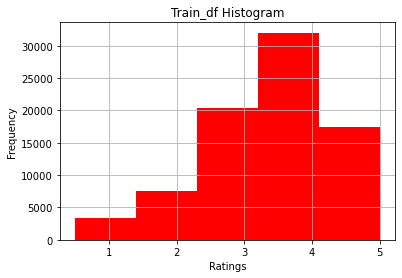

In [6]:
## INSERT AND IMPLEMENT YOUR CODE HERE
import matplotlib.pyplot as plt

plt.hist(train_df.rating, bins = 5, rwidth=1, color = 'red') 
plt.xlabel('Ratings') 
plt.ylabel('Frequency')
plt.title('Train_df Histogram')
plt.grid(True)

plt.show()

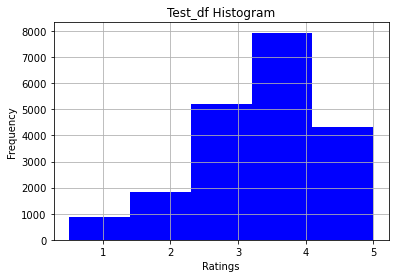

In [7]:
## INSERT AND IMPLEMENT YOUR CODE HERE
plt.hist(test_df.rating, bins = 5, rwidth=1, color = 'blue') 
plt.xlabel('Ratings') 
plt.ylabel('Frequency')
plt.title('Test_df Histogram')
plt.grid(True)

plt.show()

Both datasets present a similar distribution, which is a bit skewed to the left but still presents some sort of normal distribution.

## K-fold validation 


The previous approach tested the recommender on part of the users. If, instead, we test the recommendation on each user, we could measure the
performances much more accurately. We can split the data into some chunks, take a chunk out as the test set, and evaluate the accuracy. Then, we can do the same with each other chunk and compute the average accuracy. This approach is called k-fold
and it's supported by surprise.

An example a k-fold validation wiht K=5 is provided below. 
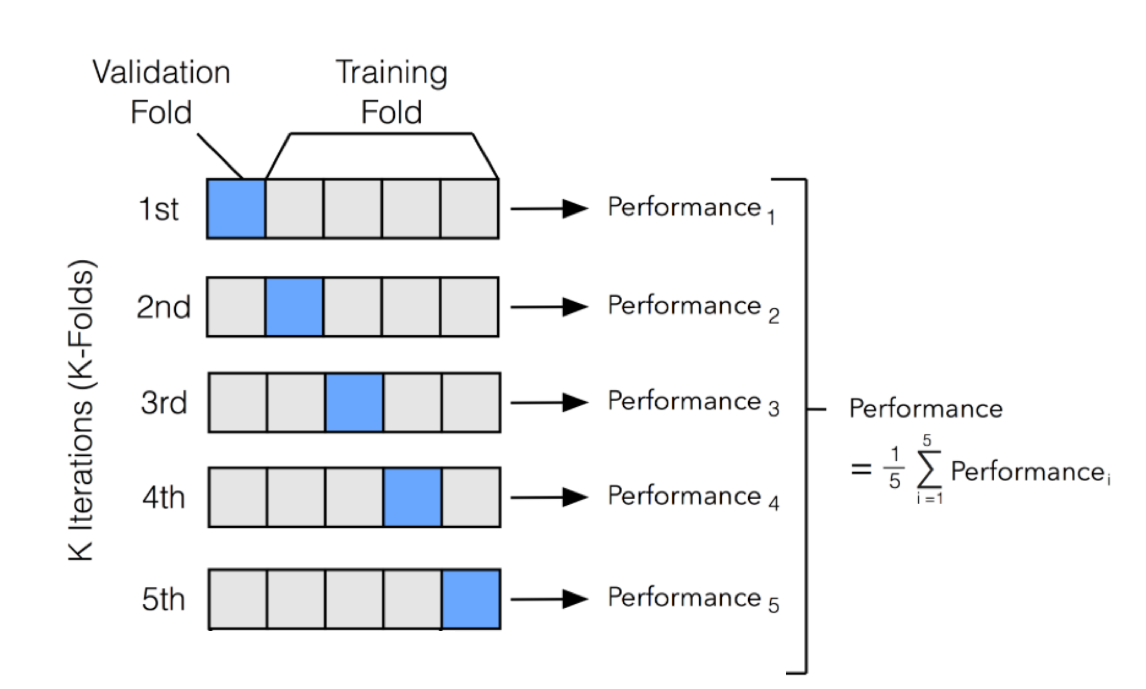

Here is an example where we use a classical K-fold cross-validation procedure with 3 splits:

In [8]:
from surprise.model_selection import KFold
kf = KFold(n_splits=3)

alg = KNNBasic()

for trainset, testset in kf.split(data_surp):

    # train and test algorithm.
    alg.fit(trainset)
    predictions = alg.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9567
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9625
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9519


### Exercise 
In previous code we split our original dataset using a k-fold validation schema, k=3. Can you create a leave one out schema?
Tip: Use LeaveOneOut from model_selection

In [9]:
## INSERT CODE HERE
from surprise.model_selection import LeaveOneOut
LOO = LeaveOneOut(n_splits=3)

alg = KNNBasic()

for trainset, testset in LOO.split(data_surp):

    # train and test algorithm.
    alg.fit(trainset)
    predictions = alg.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9792
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9439
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0059


# Evaluation Recommenders

To measure the accuracy we can use the following:
- Root mean square error (RMSE): This is the standard deviation of the difference between the real and predicted ratings (errors).
\begin{equation} 
RMSE = \sqrt{\frac{\sum_{i=1}^{N}{e_i^2}}{N}}
\end{equation}
- Mean squared error (MSE): This is the mean of the squared difference between the real and predicted ratings. It's the square of RMSE, so it contains
the same information
\begin{equation} 
MSE = \frac{\sum_{i=1}^{N}{({e})^2}}{N}
\end{equation}
- Mean absolute error (MAE): This is the mean of the absolute difference between the real and predicted ratings.
\begin{equation} 
\frac{1}{n}\sum_{i=1}^{N}|e_i|
\end{equation} 

One example on how to do it is the following:

In [10]:
knn = KNNBasic()
predictions = knn.fit(trainset).test(testset)
accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0059


1.0059297837366832

## Exercise
Change the accuracy metric to MAE and explain the difference.

In [11]:
#Insert your code here
knn = KNNBasic()
predictions = knn.fit(trainset).test(testset)
accuracy.mae(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7669


0.7669305018645964

Explanation: The RMSE tends to be larger with greater values due to its squaring operation, as well as it minimize smaller values. Meanwhile, MAE present the absolute values, following a linear behaviour, so it has no predilections for small or big errors.

## Exercise 
Compute these measures for each user

In [12]:
#Insert your code here
from surprise import KNNBasic
knn = KNNBasic()
predictions = knn.fit(trainset).test(testset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [13]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [14]:
#We import RMSE and MAE libraries

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error

df['err'] = df.est - df.rui
df

,uid,iid,rui,est,details,err
0,1,1213,5.0,4.453421,"{'actual_k': 40, 'was_impossible': False}",-0.546579
1,2,60756,5.0,3.490505,"{'actual_k': 27, 'was_impossible': False}",-1.509495
2,3,7899,4.5,3.500619,"{'was_impossible': True, 'reason': 'User and/o...",-0.999381
3,4,1885,3.0,3.113738,"{'actual_k': 11, 'was_impossible': False}",0.113738
4,5,247,5.0,3.884645,"{'actual_k': 20, 'was_impossible': False}",-1.115355
...,...,...,...,...,...,...
605,606,1280,4.0,4.355136,"{'actual_k': 8, 'was_impossible': False}",0.355136
606,607,1327,5.0,2.496086,"{'actual_k': 14, 'was_impossible': False}",-2.503914
607,608,50,4.5,4.363749,"{'actual_k': 40, 'was_impossible': False}",-0.136251
608,609,356,4.0,3.960655,"{'actual_k': 40, 'was_impossible': False}",-0.039345


In [15]:
len(pd.unique(df['uid']))

610

In [16]:
#Identify one case of example and get the results

df_1=df[df["uid"] == 1]
df_1

,uid,iid,rui,est,details,err
0,1,1213,5.0,4.453421,"{'actual_k': 40, 'was_impossible': False}",-0.546579


In [17]:
mse_1=mean_squared_error(df_1.rui,df_1.est)
mse_1

0.29874872712242034

In [18]:
mae_1=mean_absolute_error(df_1.rui,df_1.est)
mae_1

0.5465791133243387

In [19]:
#Build the rmse function for inserting it into the dataframe

def rmse(i):
    rmse = mean_squared_error(i['rui'], i['est']) # Or should it be that ? : rmse = mean_squared_error(g['r_ui'], g['est'])
    return pd.Series(dict(rmse=rmse))

rmse_df = df.groupby('uid').apply(rmse).reset_index()
rmse_df

,uid,rmse
0,1,0.298749
1,2,2.278574
2,3,0.998763
3,4,0.012936
4,5,1.244016
...,...,...
605,606,0.126122
606,607,6.269584
607,608,0.018564
608,609,0.001548


In [20]:
#Build the mae function for inserting it into the dataframe


def mae(i):
    mae = mean_absolute_error(i['rui'], i['est']) 
    return pd.Series(dict(mae=mae))

mae_df = df.groupby('uid').apply(mae).reset_index()
mae_df

,uid,mae
0,1,0.546579
1,2,1.509495
2,3,0.999381
3,4,0.113738
4,5,1.115355
...,...,...
605,606,0.355136
606,607,2.503914
607,608,0.136251
608,609,0.039345


In [22]:
#Merge the dataframe with the rmse function

df_merged_rmse=df.merge(rmse_df,on='uid', how='left')
df_merged_rmse

,uid,iid,rui,est,details,err,rmse
0,1,1213,5.0,4.453421,"{'actual_k': 40, 'was_impossible': False}",-0.546579,0.298749
1,2,60756,5.0,3.490505,"{'actual_k': 27, 'was_impossible': False}",-1.509495,2.278574
2,3,7899,4.5,3.500619,"{'was_impossible': True, 'reason': 'User and/o...",-0.999381,0.998763
3,4,1885,3.0,3.113738,"{'actual_k': 11, 'was_impossible': False}",0.113738,0.012936
4,5,247,5.0,3.884645,"{'actual_k': 20, 'was_impossible': False}",-1.115355,1.244016
...,...,...,...,...,...,...,...
605,606,1280,4.0,4.355136,"{'actual_k': 8, 'was_impossible': False}",0.355136,0.126122
606,607,1327,5.0,2.496086,"{'actual_k': 14, 'was_impossible': False}",-2.503914,6.269584
607,608,50,4.5,4.363749,"{'actual_k': 40, 'was_impossible': False}",-0.136251,0.018564
608,609,356,4.0,3.960655,"{'actual_k': 40, 'was_impossible': False}",-0.039345,0.001548


In [23]:
#Merge the new dataframe with the mae function

df_merged_rmse_mae=df_merged_rmse.merge(mae_df,on='uid', how='left')
df_merged_rmse_mae

,uid,iid,rui,est,details,err,rmse,mae
0,1,1213,5.0,4.453421,"{'actual_k': 40, 'was_impossible': False}",-0.546579,0.298749,0.546579
1,2,60756,5.0,3.490505,"{'actual_k': 27, 'was_impossible': False}",-1.509495,2.278574,1.509495
2,3,7899,4.5,3.500619,"{'was_impossible': True, 'reason': 'User and/o...",-0.999381,0.998763,0.999381
3,4,1885,3.0,3.113738,"{'actual_k': 11, 'was_impossible': False}",0.113738,0.012936,0.113738
4,5,247,5.0,3.884645,"{'actual_k': 20, 'was_impossible': False}",-1.115355,1.244016,1.115355
...,...,...,...,...,...,...,...,...
605,606,1280,4.0,4.355136,"{'actual_k': 8, 'was_impossible': False}",0.355136,0.126122,0.355136
606,607,1327,5.0,2.496086,"{'actual_k': 14, 'was_impossible': False}",-2.503914,6.269584,2.503914
607,608,50,4.5,4.363749,"{'actual_k': 40, 'was_impossible': False}",-0.136251,0.018564,0.136251
608,609,356,4.0,3.960655,"{'actual_k': 40, 'was_impossible': False}",-0.039345,0.001548,0.039345


## Exercise 

Draw a distribution graph of the errors. Comment the results

C:\Users\Hp\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Hp\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level functi

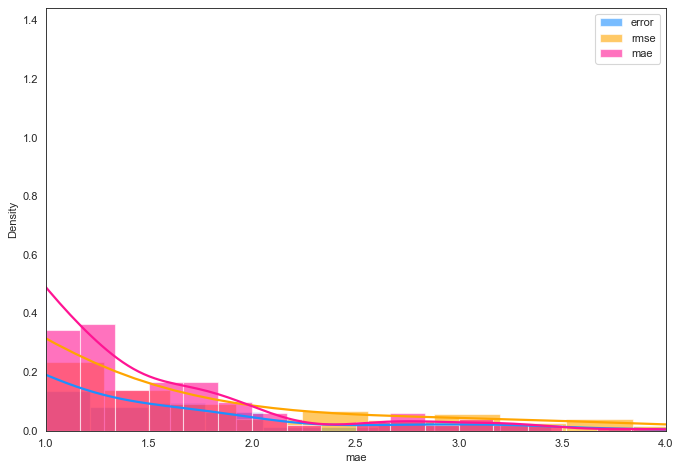

In [25]:
## INSERT CODE HERE
import seaborn as sns
sns.set_style("white")

x1 = df_merged_rmse_mae['err']
x2 = df_merged_rmse_mae['rmse']
x3 = df_merged_rmse_mae['mae']

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="error", **kwargs)
sns.distplot(x2, color="orange", label="rmse", **kwargs)
sns.distplot(x3, color="deeppink", label="mae", **kwargs)
plt.xlim(1,4)
plt.legend();

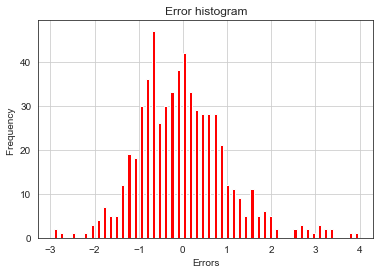

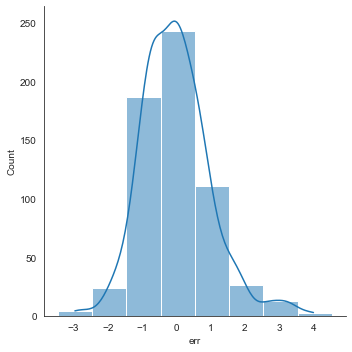

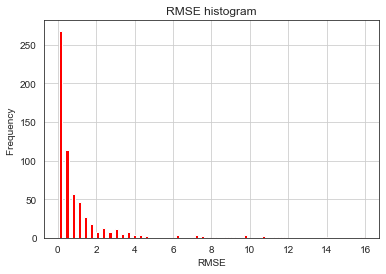

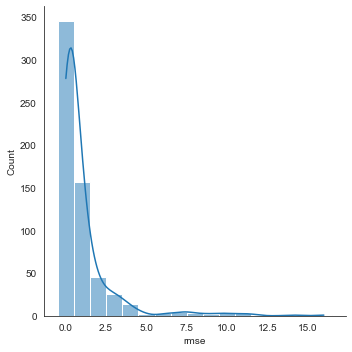

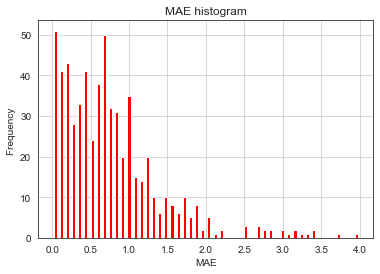

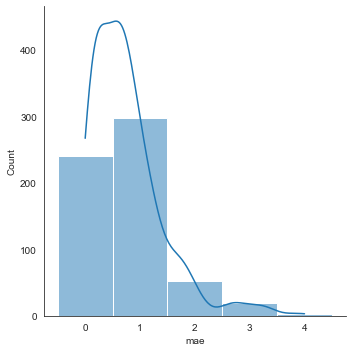

In [26]:
plt.hist(df_merged_rmse_mae.err, bins = 50, rwidth=0.5, color = 'red') 
plt.xlabel('Errors') 
plt.ylabel('Frequency ')
plt.title('Error histogram')
plt.grid(True)
sns.displot(df_merged_rmse_mae.err, discrete = True, kde = True)

plt.show()

plt.hist(df_merged_rmse_mae.rmse, bins = 50, rwidth=0.5, color = 'red') 
plt.xlabel('RMSE') 
plt.ylabel('Frequency ')
plt.title('RMSE histogram')
plt.grid(True)
sns.displot(df_merged_rmse_mae.rmse, discrete = True, kde = True)

plt.show()

plt.hist(df_merged_rmse_mae.mae, bins = 50, rwidth=0.5, color = 'red') 
plt.xlabel('MAE') 
plt.ylabel('Frequency ')
plt.title('MAE histogram')
plt.grid(True)
sns.displot(df_merged_rmse_mae.mae, discrete = True, kde = True)

plt.show()

Explanation: As observed in the previous graphs, MAE tends to recreate the real difference within errors; meanwhile, RMSE made smaller values even smaller and the large ones even larger. This made that the histogram was drastically skewed to the right. Also, in the density graph it is observed how RMSE present lower errors that MAE, while when the value is larger the roles become the opposite.

# Evaluating the recommendation


Another way to measure accuracies is by comparing the recommendations with the purchases having a positive rating. Weneed to define a threshold for positive ratings

Let's recap the metrics for classification. 

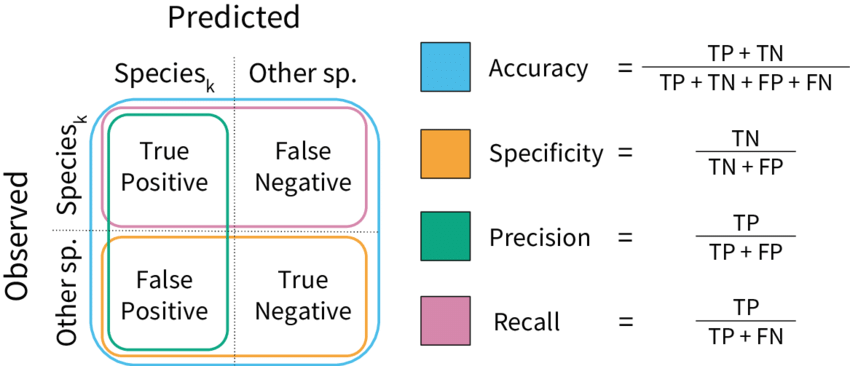

First, let's build the ROC curve. It displays these factors:
- **True Positive Rate (TPR):** This is the percentage of rated items that have been recommended. It's the number of TP divided by the number of rated items (TP + FN).
- **False Positive Rate (FPR)**: This is the percentage of not rated items that have been recommended. It's the number of FP divided by the number of not
rated items (FP + TN).

- **Precision:** This is the percentage of recommended items that have been rated. It's the number of FP divided by the total number of positives (TP + FP).
- **Recall:** This is the percentage of purchased items that have been recommended. It's the number of TP divided by the total number of rated (TP + FN). It's also equal to the True Positive Rate.

In [27]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [28]:
from surprise import KNNBasic
from surprise.model_selection import KFold


kf = KFold(n_splits=5)
alg = KNNBasic()

for trainset, testset in kf.split(data_surp):
    alg.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.1)

    # Precision and recall can then be averaged over all users
    print("Precision:"+str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("Recall:"+str(sum(rec for rec in recalls.values()) / len(recalls)))
    
    

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7821526633717759
Recall:0.4692856958885565
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7556830601092919
Recall:0.4562463809844548
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7693212917350871
Recall:0.4508787391959505
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.763497267759565
Recall:0.44968276450191264
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7714480874316966
Recall:0.45739150343932966


## Exercise
Change the previous code to increase the Recall. Explain your results

In [201]:
#Insert your code here
from surprise import KNNBasic
from surprise.model_selection import KFold


kf = KFold(n_splits=5)
alg = KNNBasic()

for trainset, testset in kf.split(data_surp):
    alg.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.1)

    # Precision and recall can then be averaged over all users
    print("Precision:"+str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("Recall:"+str(sum(rec for rec in recalls.values()) / len(recalls)))

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7405516523549314
Recall:0.61965452757147
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7397924798334637
Recall:0.6206240221845195
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.750768930523029
Recall:0.6200517543310179
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7533433679985408
Recall:0.6180441349942858
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7380405035577456
Recall:0.6174666339206097


Explanation: In this case the threshold is the same; however the K changes from 5 to 10. Thanks to this adaptation the Recall increases, but this happens because the model is now accepting more potential positives with less considerations. 

## Comparing model and identifying the best

In order to evaluate different models, we can define a list with them. 

In [29]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithZScore,0.902855,0.252406,3.145901
KNNWithMeans,0.904492,0.213078,3.164397
KNNBasic,0.956614,0.262448,3.542952
KNNBasic,0.956624,0.309709,3.320775
KNNBasic,0.958597,0.153673,2.194544


## Exercise
Compute the benchmark using the best options you got in your parameter tunning for each algorithm

In [204]:
#Insert your code here
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNWithZScore,0.896150,0.679582,0.534831,3.740685
KNNWithMeans,0.896317,0.684583,0.425871,3.268250
KNNBasic,0.946244,0.725059,0.382828,2.988554
KNNBasic,0.946901,0.725930,0.375237,2.889607
KNNBasic,0.947318,0.726228,0.378123,2.984456


In [205]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE', 'MAE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNWithMeans,0.889089,0.679219,0.621375,1.058300
KNNWithZScore,0.889208,0.674544,0.745916,1.128421
KNNBasic,0.936730,0.717310,0.580198,0.983065
KNNBasic,0.937170,0.717724,0.588122,1.016692
KNNBasic,0.937219,0.717924,0.554223,0.957870


In [207]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE', 'MAE'], cv=35, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNWithZScore,0.887581,0.673503,0.747666,0.700476
KNNWithMeans,0.889207,0.679399,0.610027,0.605577
KNNBasic,0.935849,0.716515,0.581844,0.564623
KNNBasic,0.935919,0.716780,0.611692,0.609303
KNNBasic,0.936036,0.717111,0.604998,0.588468


In [208]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE', 'MAE'], cv=50, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNWithZScore,0.887110,0.673162,0.721422,0.459411
KNNWithMeans,0.888246,0.678678,0.607315,0.424727
KNNBasic,0.934788,0.715878,0.568544,0.405559
KNNBasic,0.935133,0.716156,0.598969,0.451555
KNNBasic,0.935444,0.716369,0.563819,0.408499


In [209]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE', 'MAE'], cv=100, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNWithZScore,0.886723,0.673091,0.737599,0.267800
KNNWithMeans,0.887801,0.678461,0.625298,0.262897
KNNBasic,0.934364,0.715711,0.608414,0.252698
KNNBasic,0.934500,0.715828,0.599937,0.251991
KNNBasic,0.934896,0.715933,0.580779,0.245340


In [210]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=40),KNNBasic(k=30), KNNBasic(k=20), KNNWithMeans(k=20), KNNWithZScore(k=35)]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE', 'MAE'], cv=35, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNWithZScore,0.887934,0.673894,0.777588,0.669631
KNNWithMeans,0.889933,0.681137,0.639067,0.547549
KNNBasic,0.927168,0.707384,0.591675,0.522887
KNNBasic,0.931984,0.712795,0.657377,0.595206
KNNBasic,0.935896,0.716737,0.602029,0.620949


In [32]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=40),KNNBasic(k=30), KNNBasic(k=20), KNNWithMeans(k=30), KNNWithZScore(k=60)]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE', 'MAE'], cv=35, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
KNNWithZScore,0.887729,0.673433,0.344438,0.332572
KNNWithMeans,0.888584,0.679369,0.297338,0.264067
KNNBasic,0.927304,0.707474,0.267800,0.218274
KNNBasic,0.932709,0.713012,0.277364,0.243154
KNNBasic,0.935757,0.716794,0.245705,0.232809


Explanation: So after several trials, it can be said that the best model has between 30 and 35 cross validations (Folds), and that in all of the cases, the KNNWithZScore was the best. Considering that, an efficient K that could work is 60. Apparently standardizing the values help to minimize the potential errors.

## Exercise
Obtain the best algorithm you can using what you have learnt and any other resource you want.

In [ ]:
#Insert your code here
from surprise import SVDpp
from surprise import NMF
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), SVDpp(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000019CFF0FAFA0>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x0000019CFF0FA6A0>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x0000019CFF0FACA0>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x0000019C812135B0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x0000019C81213640>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x0000019C812137C0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x0000019C81213700>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x0000019C812137F0>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x0000019C81213A30>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x0000019C812139D0>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000019CFF0FAFA0>
Done:  <surprise.prediction

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [37]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.927468,107.685080,4.066488
KNNBaseline,0.935972,0.404931,4.784257
SVD,0.943941,2.955767,0.312179
BaselineOnly,0.947138,0.146631,0.191469
KNNWithMeans,0.957092,0.284949,4.174355
KNNWithZScore,0.957150,0.325213,4.541739
CoClustering,0.976681,1.419623,0.283582
NMF,0.977086,3.420868,0.280602
KNNBasic,0.988303,0.259558,3.882936


Explanation: After exploring different algorithms, the best results were obtained from the SVDpp model, which is an extension of a probabilistic matrix factorization that considers implicit ratings.

# Content based
Content based algorithms use the content and descriptions of the products/items. In the case of films we can use the tags, genres, year of production, etc. to predict the rating of a user u to an item i.

We can create a training matrix in the way we are used to for machine learning problems or we can use different types of distances.

In this case we are using the tags for the films which are in the genome-scores and genome-tags files. 

## Exercise
Read them and create a dataframe df_tags with the following format:
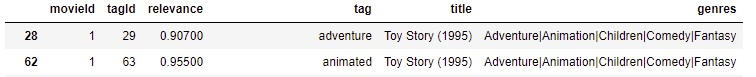

In [35]:
#Insert your code here

import pandas as pd

genome_scores = pd.read_csv("genome-scores.csv")
genome_tags = pd.read_csv("genome-tags.csv")
genome_merged = genome_scores.merge(genome_tags,on='tagId', how='left')
genome_merged.head()

,movieId,tagId,relevance,tag
0,1,1,0.02900,007
1,1,2,0.02375,007 (series)
2,1,3,0.05425,18th century
3,1,4,0.06875,1920s
4,1,5,0.16000,1930s


In [4]:
df_tags=genome_merged.merge(movielens_meta,on='movieId',how='left')
df_tags.head()

,movieId,tagId,relevance,tag,title,genres
0,1,1,0.02900,007,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,2,0.02375,007 (series),Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,1,3,0.05425,18th century,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,1,4,0.06875,1920s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,1,5,0.16000,1930s,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## Exercise
Inspect the dataframe for movieId==1 (Toy Story). Do you think all the tags are useful?

In [5]:
#Insert your code here
toystory_df = df_tags[df_tags.movieId==1]
toystory_df.sort_values(by='relevance')

,movieId,tagId,relevance,tag,title,genres
1001,1,1002,0.00200,swedish,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
488,1,489,0.00225,hannibal lecter,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1068,1,1069,0.00300,vampires,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
592,1,593,0.00350,kurosawa,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
975,1,976,0.00375,studio ghibli,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
588,1,589,0.98850,kids and family,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
63,1,64,0.98875,animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
785,1,786,0.99550,pixar animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
243,1,244,0.99900,computer animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Not all tags seem relevant as they have no connection to the content or characteristics of the movie Toy Story. In some cases it is observable tags that make no sense such as vampires, swedish, hannibal lecter, and so on.

## Exercise

Solve the previous problem to reduce data and explain the solution.

In [6]:
#Inser your code here

#First the genres is dropped as it makes no difference

toystory_df_drop=toystory_df.drop(columns=['genres'])
toystory_df_drop

,movieId,tagId,relevance,tag,title
0,1,1,0.02900,007,Toy Story (1995)
1,1,2,0.02375,007 (series),Toy Story (1995)
2,1,3,0.05425,18th century,Toy Story (1995)
3,1,4,0.06875,1920s,Toy Story (1995)
4,1,5,0.16000,1930s,Toy Story (1995)
...,...,...,...,...,...
1123,1,1124,0.04550,writing,Toy Story (1995)
1124,1,1125,0.02000,wuxia,Toy Story (1995)
1125,1,1126,0.03850,wwii,Toy Story (1995)
1126,1,1127,0.09125,zombie,Toy Story (1995)


In [7]:
#The different set of relevances are counted so there is an idea of the dataset

toystory_df_drop['relevance'].value_counts(ascending=False)

0.02400    8
0.01925    7
0.02425    6
0.02875    6
0.01175    6
          ..
0.24325    1
0.13375    1
0.16050    1
0.16125    1
0.16375    1
Name: relevance, Length: 724, dtype: int64

In [8]:
#After observing the tags and the relevance, rows tha present a relevance lower than 0.4 are dropped

toystory_df_final = toystory_df_drop[toystory_df_drop['relevance'] > 0.4]
print(toystory_df_final)

      movieId  tagId  relevance                tag             title
10          1     11    0.58700                 3d  Toy Story (1995)
18          1     19    0.66825             action  Toy Story (1995)
28          1     29    0.90700          adventure  Toy Story (1995)
29          1     30    0.60850       affectionate  Toy Story (1995)
60          1     61    0.59575       animal movie  Toy Story (1995)
...       ...    ...        ...                ...               ...
1089        1   1090    0.48100             visual  Toy Story (1995)
1091        1   1092    0.52750  visually stunning  Toy Story (1995)
1103        1   1104    0.42850              weird  Toy Story (1995)
1107        1   1108    0.60275          whimsical  Toy Story (1995)
1113        1   1114    0.71175              witty  Toy Story (1995)

[118 rows x 5 columns]


Explanation: With this final adaptation, the tags make certain sense and are directly or indirectly connected to the mentioned movie.

We are going to create the model using the tags and some Natural Language Processing methods to convert the words into vectors to create a metric to compare between those words. We are going to use the packages: gensim and nltk for this purpose.

In [9]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
tags_corpus = df_tags.tag.values


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
    tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
    return tokens

We create a list of Documments. Each document represents a film and it has the tags of that film. 

In [12]:
tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(tags_corpus)]

We are using Doc2Vec to create a vector representation of each film

In [13]:
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0) # paragraph vector distributed bag-of-words (PV-DBOW)

model.build_vocab(tags_doc)

We train the model to represent the films in vectors.

In [ ]:
max_epochs = 50

for epoch in range(max_epochs):
    print(epoch, end = ' ')
    model.train(tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

We compare films by measuring distances among vectors.

In [ ]:
mv = 'Toy Story (1995)'
tags_vectors = model.docvecs.vectors_docs
mv_index = df_tags[df_tags["title"] == mv].index.values[0]

print(tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
    print(int(i))
    print(df_tags.loc[int(i), "title"].strip())

# Optional

Create any other model that you think could be useful.

For example, you could create a training matrix for predicting the rating as if you were in a machine learning problem. Evaluate your results